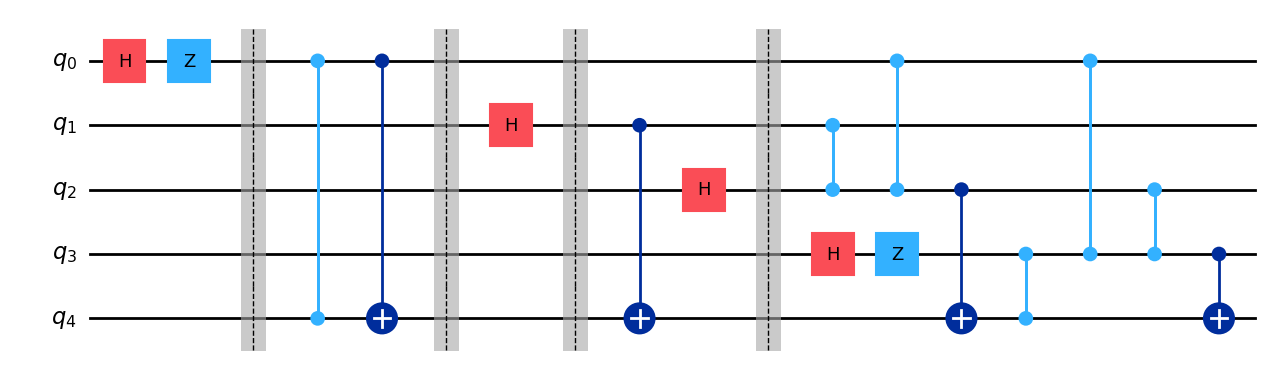

|L0> fidelity: 0.9999999999999993
|L1> fidelity: 0.9999999999999993
|L+> fidelity: 0.0
|L-> fidelity: 0.0


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Statevector, Pauli, state_fidelity
from qiskit_aer.noise import pauli_error
import matplotlib.pyplot as plt

# Stabilizers (cyclic form) and logical Z
G = ["XZZXI", "IXZZX", "XIXZZ", "ZXIXZ"]
ZL = Pauli("ZZZZZ")
XL = Pauli("XXXXX")
n = len(G[0])
k = n - len(G)

syndrome_to_fix = {
    "1000": ("X", 0), "1101": ("Y", 0), "0101": ("Z", 0),
    "0001": ("X", 1), "1011": ("Y", 1), "1010": ("Z", 1),
    "0011": ("X", 2), "0111": ("Y", 2), "0100": ("Z", 2),
    "0110": ("X", 3), "1111": ("Y", 3), "1001": ("Z", 3),
    "1100": ("X", 4), "1110": ("Y", 4), "0010": ("Z", 4),
}
# Logical |0_L> for the [[5,1,3]] code
logical_zero_plus_terms  = ["00000","10010","01001","10100","01010","00101"]
logical_zero_minus_terms = ["11011","00110","11000","11101","00011","11110","01111","10001","01100","10111"]

amps = np.zeros(32, dtype=complex)
for b in logical_zero_plus_terms:
    amps[int(b,2)] += 1/4
for b in logical_zero_minus_terms:
    amps[int(b,2)] -= 1/4

L_zero = Statevector(amps)

# Logical |1_L> = X^{⊗5} |0_L>
amps_1 = np.zeros(32, dtype=complex)
for b in logical_zero_plus_terms:
    flipped = ''.join('1' if x == '0' else '0' for x in b)
    amps_1[int(flipped, 2)] += 1/4
for b in logical_zero_minus_terms:
    flipped = ''.join('1' if x == '0' else '0' for x in b)
    amps_1[int(flipped, 2)] -= 1/4

L_one = Statevector(amps_1)

L_plus = Statevector((L_zero.data + L_one.data) / np.sqrt(2))
L_minus = Statevector((L_zero.data - L_one.data) / np.sqrt(2))

def encoder_5q(x1, x2):
    if x1 == 0 and x2 == 1:
        qc = QuantumCircuit(5, name ="|L1> encoder")
        qc.x(4)
    elif x1 == 1 and x2 == 0:
        qc = QuantumCircuit(5, name ="|L+> encoder")
        qc.h(4)
    elif x1 == 1 and x2 == 1:
        qc = QuantumCircuit(5, name ="|L-> encoder")
        qc.x(4)
        qc.h(4)
    else:
        qc = QuantumCircuit(5, name ="|L0> encoder")

    qc.h(0)
    qc.z(0)
    qc.barrier()
    qc.cz(0, 4)
    qc.cx(0, 4)
    qc.barrier()
    qc.h(1)
    qc.barrier()
    qc.cx(1, 4)
    qc.h(2)
    qc.barrier()
    qc.cz(2, 1)
    qc.cz(2, 0)
    qc.cx(2, 4)
    qc.h(3)
    qc.z(3)
    qc.cz(3, 4)
    qc.cz(3, 0)
    qc.cz(3, 2)
    qc.cx(3, 4)

    return qc

display(encoder_5q(0, 0).draw(output="mpl"))


print("|L0> fidelity:", state_fidelity(Statevector.from_instruction(encoder_5q(0, 0)), L_zero))
print("|L1> fidelity:", state_fidelity(Statevector.from_instruction(encoder_5q(0, 1)), L_one))
print("|L+> fidelity:", state_fidelity(Statevector.from_instruction(encoder_5q(1, 0)), L_plus))
print("|L-> fidelity:", state_fidelity(Statevector.from_instruction(encoder_5q(1, 1)), L_minus))

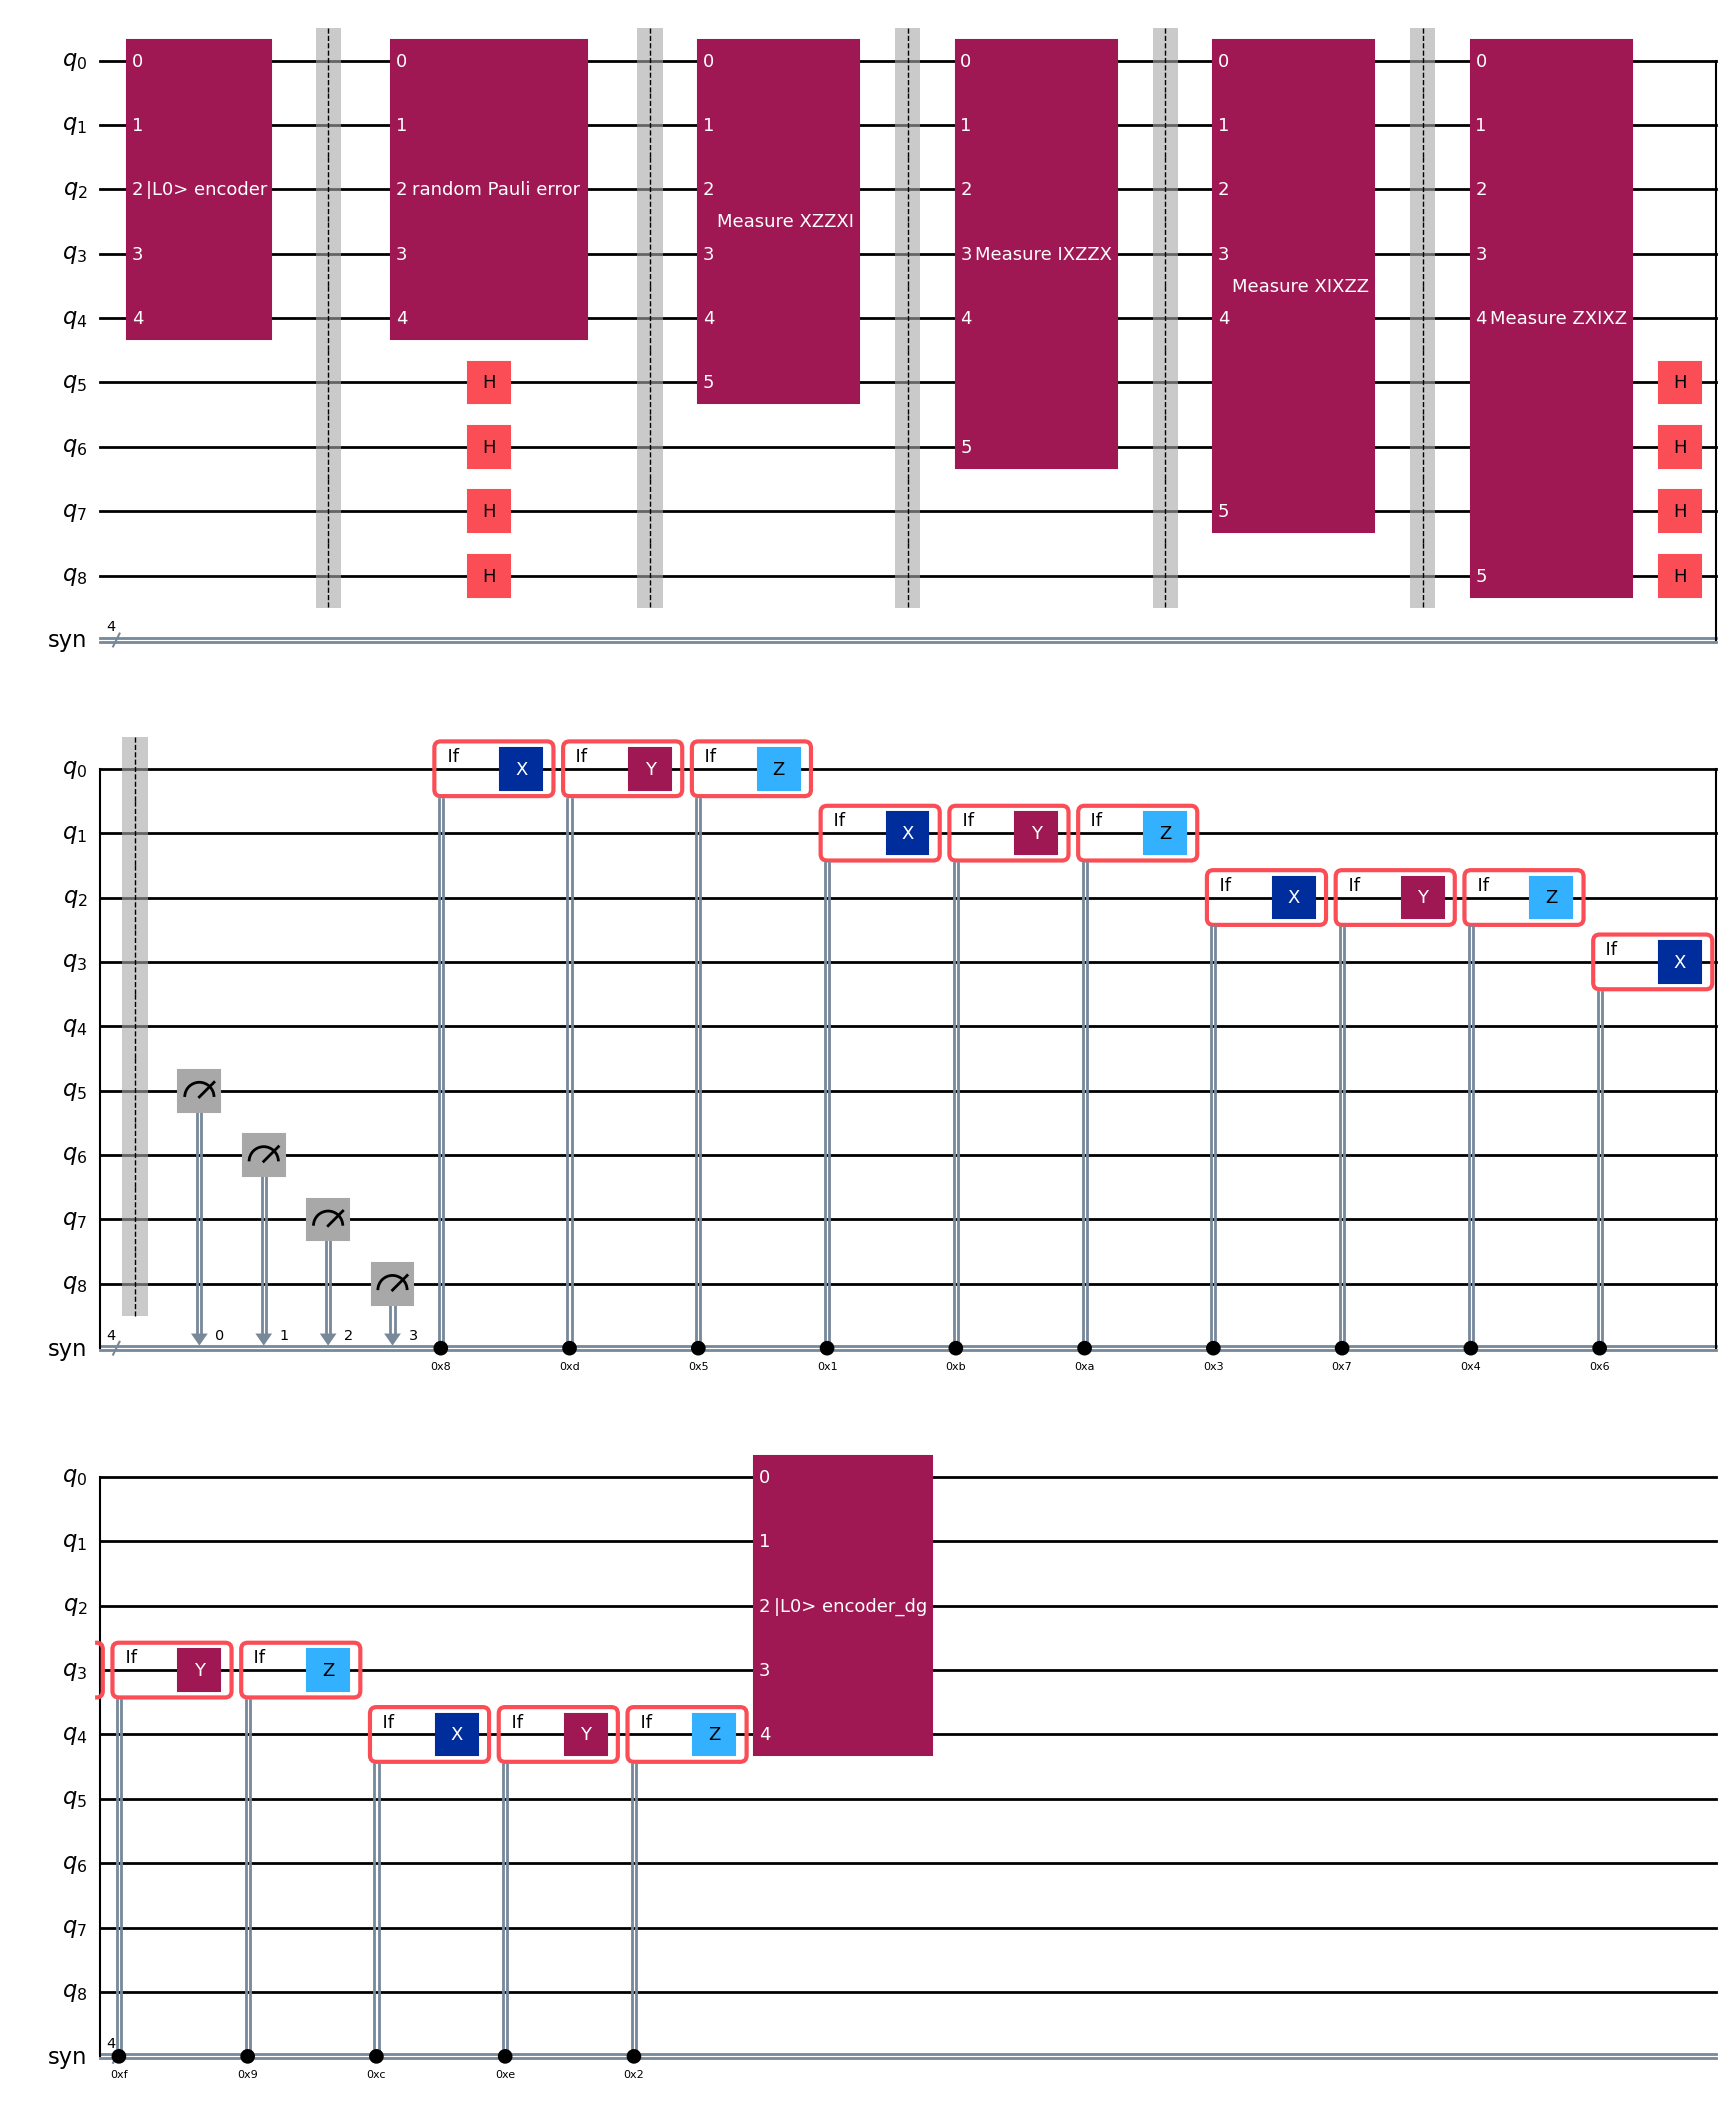

In [16]:
def pauli_error_on_all_data_qubits(p) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="random Pauli error")
    err = pauli_error([('X', p), ('Y', p), ('Z', p), ('I', 1 - 3 * p)])
    for i in range(5):
        qc.append(err.to_instruction(), [i])

    return qc

def measure_stabilizer(p_string) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name=f"Measure {p_string}")
    for i, p in enumerate(p_string):
        if p == 'X':
            qc.cx(n, i)
        elif p == 'Z':
            qc.cz(n, i)

    return qc

def build_5q_code_circuit(p, x1, x2) -> QuantumCircuit:
    L_zero_encoder = encoder_5q(x1, x2)
    qc_5q = QuantumCircuit(2 * n - k)
    qc_5q.append(L_zero_encoder, range(n))
    qc_5q.barrier()
    qc_5q.append(pauli_error_on_all_data_qubits(p), range(n))

    # Syndrome extraction
    qc_5q.h(range(n, n + n - k))
    for i in range(n - k):
        qc_5q.barrier()
        qc_5q.append(measure_stabilizer(G[i]), list(range(n)) + [n + i])

    qc_5q.h(range(n, n + n - k))

    qc_5q.barrier()
    syn = ClassicalRegister(n - k, "syn")
    qc_5q.add_register(syn)
    qc_5q.measure(range(n, n + n - k), syn)

    def apply_fix(pauli, q):
        if pauli == "X":
            qc_5q.x(q)
        elif pauli == "Z":
            qc_5q.z(q)
        else:
            qc_5q.y(q)

    for s, (pauli, q) in syndrome_to_fix.items():
        val = int(s, 2)           # keys already reversed -> direct parse
        with qc_5q.if_test((syn, val)):
            apply_fix(pauli, q)


    qc_5q.append(L_zero_encoder.inverse(), range(n))
    
    return qc_5q

qc = build_5q_code_circuit(0.1, 0, 0)
display(qc.draw(output="mpl"))

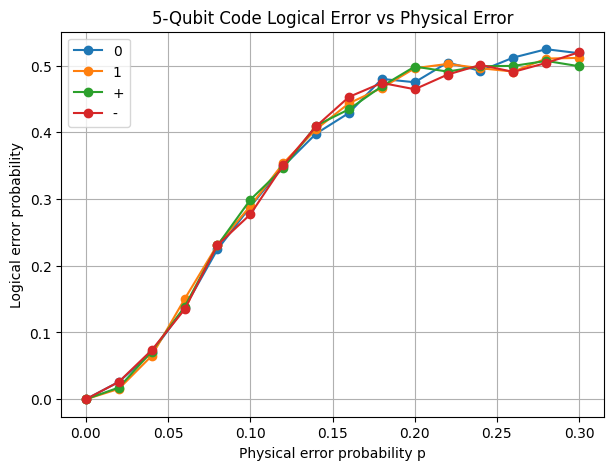

In [56]:
from qiskit import transpile
from qiskit.result import marginal_counts
from qiskit_aer import Aer

def run_5q_code(p, x1, x2, n_shots):
    qc = build_5q_code_circuit(p, x1, x2)
    qc.measure_all()

    # Run on simulator
    sim = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots = n_shots).result()
    counts = result.get_counts()
    marginal_4 = marginal_counts(counts, indices=range(4, 9))

    return 1 - (marginal_4["00000"] / n_shots)

n_shots = 2000

# physical error probabilities
p_values = np.linspace(0, 0.3, 16)

# placeholders
results = {
    "0": [],
    "1": [],
    "+": [],
    "-": []
}

# sweep p for each logical state
for p in p_values:
    results["0"].append(run_5q_code(p, 0, 0, n_shots))
    results["1"].append(run_5q_code(p, 0, 1, n_shots))
    results["+"].append(run_5q_code(p, 1, 0, n_shots))
    results["-"].append(run_5q_code(p, 1, 1, n_shots))

# plot all
plt.figure(figsize=(7,5))
for label, vals in results.items():
    plt.plot(p_values, vals, marker='o', label=label)

plt.xlabel("Physical error probability p")
plt.ylabel("Logical error probability")
plt.title("5-Qubit Code Logical Error vs Physical Error")
plt.legend()
plt.grid(True)
plt.show()